# Voting Classifiers

In [1]:
#Let's get the moon dataset to analyze
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)


In [2]:
#We can make a voting classifier composed of 3 diverse classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
                estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                voting='hard')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
#Let's look at each classifiers accuracy on the test set
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.896


 # Bagging and Pasting

In [4]:
#Let's perform bagging with Scikit-Learn. We will train 500 decision tree classifiers, which are each trained on 100 training instances
#randomly sampled from the training set with replacement (this is bagging, but you can perform pasting instead by setting
#bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU cores for training and predictions (-1 tells Scikit-Learn
#to use all available cores).
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.912


In [5]:
#We can evaluate our bagging classifiers with the oob score
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [6]:
#This means that our classifier is likely to be 89.9% accurate on the test set. We can also view the oob_decision_function_, which
#reveals the decision function for each training instance.
bag_clf.oob_decision_function_

array([[0.35416667, 0.64583333],
       [0.3814433 , 0.6185567 ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09142857, 0.90857143],
       [0.33516484, 0.66483516],
       [0.00995025, 0.99004975],
       [0.98809524, 0.01190476],
       [0.95767196, 0.04232804],
       [0.82065217, 0.17934783],
       [0.00531915, 0.99468085],
       [0.75126904, 0.24873096],
       [0.86315789, 0.13684211],
       [0.96236559, 0.03763441],
       [0.07734807, 0.92265193],
       [0.        , 1.        ],
       [0.984375  , 0.015625  ],
       [0.95212766, 0.04787234],
       [0.99441341, 0.00558659],
       [0.0104712 , 0.9895288 ],
       [0.33668342, 0.66331658],
       [0.92134831, 0.07865169],
       [1.        , 0.        ],
       [0.98924731, 0.01075269],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.61176471, 0.38823529],
       [0.

In [7]:
#This can be interpreted as, for instance, the oob evaluation estimates that the first training instance has a 61.8% probability of belonging
#to the positive class and a 38.2% of belonging to the negative class

# Random Forests

In [8]:
#The following code uses all available CPU cores to train a Random Forest classifier with 500 trees (each limited to 16 nodes)
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

In [9]:
#The following code creates a BaggingClassifier that is roughly equivalent to the RandomForestClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [10]:
#One great benefit of Random Forests is that they can easily find the relative importance of each feature. We will show this using the iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10712585199833033
sepal width (cm) 0.02645313142401074
petal length (cm) 0.40887279051840814
petal width (cm) 0.45754822605925083


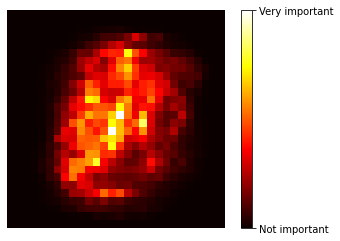

In [11]:
#Similarly, if you train a Random Forest on the MNIST dataset and plot each pixel's importance, you would get an image like below
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# Boosting

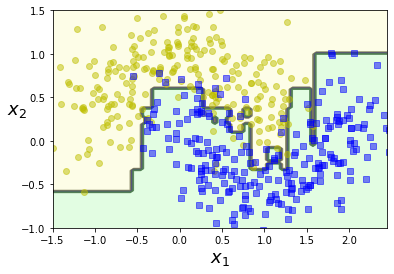

In [12]:
#Let's take a look at the initial decision boundary for an ensemble of Decision Trees that implement AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(x_train, y_train)
plot_decision_boundary(ada_clf, x, y)

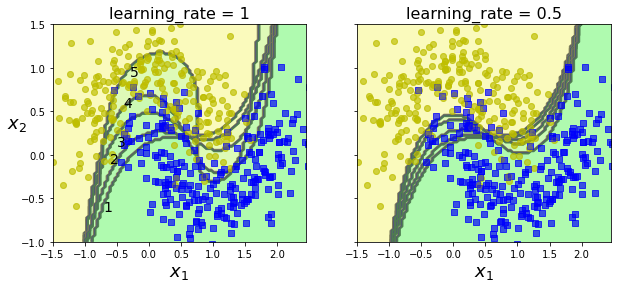

In [13]:
#We can now see how AdaBoost helps to dramatically increase the model's accuracy over time
m = len(x_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(x_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(x_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, x, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

In [14]:
#Let's shift our focus to Gradient boosting. We can see it work on a simple regression example. First we can fit a 
#DecisionTreeRegressor to our dataset, which will be created in the code below
np.random.seed(42)
x = np.random.rand(100, 1) - 0.5
y = 3*x[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(x, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [15]:
#Next we will train a second DecisionTreeRegressor on the residual error made by the first one
y2 = y - tree_reg1.predict(x)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(x, y2)

DecisionTreeRegressor(max_depth=2)

In [16]:
#Then we train a third regressor on the residual errors made by the second one
y3 = y2 - tree_reg2.predict(x)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(x, y3)

DecisionTreeRegressor(max_depth=2)

In [17]:
#Now we have an ensemble containing 3 learning trees. It can make a prediction on a new instance simply by adding up the predictions
#of all of the trees
x_new = np.array([[0.8]])
y_pred = sum(tree.predict(x_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


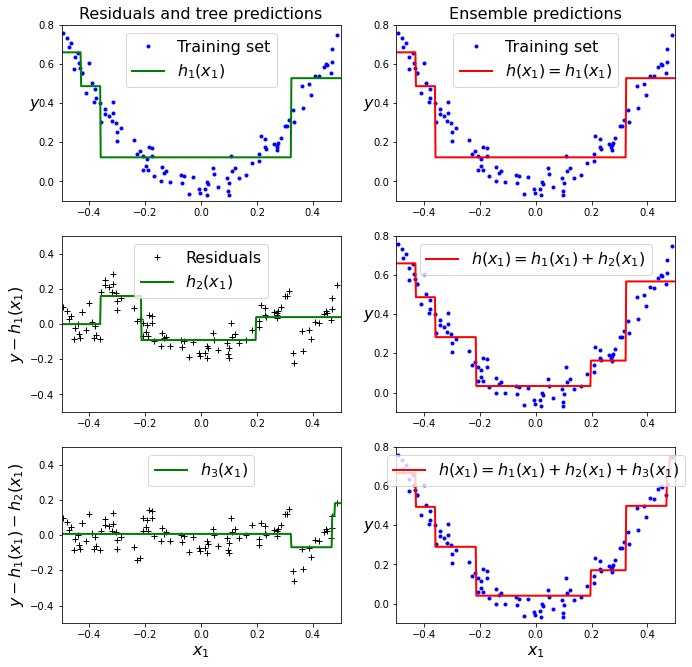

In [18]:
#Let's look at each of these trees and the ensemble in action
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], x, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], x, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], x, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], x, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], x, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], x, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [19]:
#In the left column is the predictions of the three trees, and in the right column is the ensembles predictions.
#In the first row, the ensemble has just one tree so its predictions are identical to that of the tree.
#In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that
#the ensemble's predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another
#tree is trained on the residual errors of the second tree. The ensemble's predictions gradually get better as more trees are added.

#However, there are much simpler ways to perfrom Gradient Boosting Regression, such as Scikit-Learn's class. The code below creates an identical
#ensemble to the previous one.
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(x, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [20]:
#In order to find the optimal learning rate, you can use early stopping. A simpler way would be to use the staged_predict()
#method: it returns an iterator over the predictions made by the ensemble at each stage of the training. The following
#code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees,
#and finally trains another GBRT with the optimal number of trees
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_val, y_train, y_val = train_test_split(x, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(x_train, y_train)
errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(x_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=53)

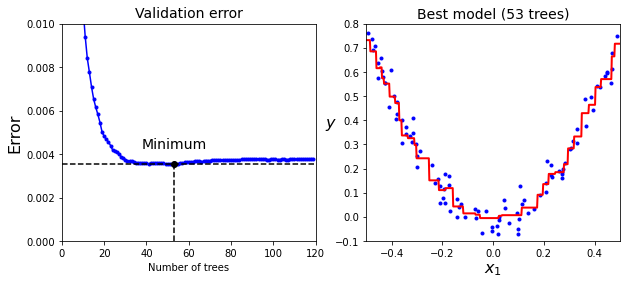

In [21]:
#We can display the validation errors (left graph) and the best model's predictions (right graph)
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], x, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [22]:
#It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then
#looking back to find the optimal number). You do so by setting warm_start=True, which makes Scikit-Learn keep existing trees
#when the fit() method is called, allowing for incremential training. This can be seen below

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train, y_train)
    y_pred = gbrt.predict(x_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)

47


In [24]:
#The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for
#training each tree. This technique trades a higher bias for a lower variance, and also speeds things up considerably. This is called
#Stochastic Gradient Boosting

#It is worth noting that an optimized implementation of Gradient Boosting can be found in the popular python library XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train)
y_pred = xgb_reg.predict(x_val)

# That's it for random forests. The book also discussed Stacking, which is another type of ensemble model. However, stacking is not directly supported by Scikit-Learn, and thus was not shown as an example in the book.